Setup: Imports & Data Generation

In [87]:
# Standard libraries
from objective_functions import compute_objective
from prox_operators import prox_l1, prox_elastic_net
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import iterative_solvers
import importlib

importlib.reload(iterative_solvers)

# now re-import the functions
from iterative_solvers import estimate_lipschitz, ista, fista, fista_delta

# Data generation utilities
from easy_boston_data import (
    generate_correlated_boston_like_data
)

# Core solvers
from iterative_solvers import ista, fista, fista_delta
from lbfgs import LBFGSSolver

# Global stopping tolerance for all solvers
# The value 1e-6 ensures convergence to a solution where:
#   ‖∇f(x_k)‖₂ ≤ ε   or   ‖x_{k+1} − x_k‖₂ ≤ ε
# which are both standard criteria in the slides.
# This threshold balances numerical precision and practical stopping.
TOL = 1e-10


Preprocessing & Regularization Settings

In [88]:
# 3.1.1 Generate correlated data & standardize
A, b, x_true = generate_correlated_boston_like_data(m=1000, noise_std=1.0)
A = (A - A.mean(axis=0)) / A.std(axis=0)
b = b - b.mean()

# 3.1.2 Define regularization scenarios
basic_regs = [
    # Pure Lasso variants (α₂=0)
    {'name': 'lasso', 'alpha1': 0.3, 'alpha2': 0.0},
    {'name': 'lasso', 'alpha1': 0.6, 'alpha2': 0.0},
    {'name': 'lasso', 'alpha1': 1.0, 'alpha2': 0.0},

    # Pure Ridge variants (α₁=0)
    {'name': 'ridge', 'alpha1': 0.0, 'alpha2': 0.3},
    {'name': 'ridge', 'alpha1': 0.0, 'alpha2': 0.6},
    {'name': 'ridge', 'alpha1': 0.0, 'alpha2': 1.0},

    # Elastic Net ≃ Lasso (α₂ very small < eps)
    {'name': 'elasticnet', 'alpha1': 0.3, 'alpha2': 1e-9},

    # Elastic Net ≃ Ridge (α₁ very small < eps)
    {'name': 'elasticnet', 'alpha1': 1e-6, 'alpha2': 0.5},

    # Balanced Elastic Net (both >> eps)
    {'name': 'elasticnet', 'alpha1': 0.3, 'alpha2': 0.3},
]




Baseline: ISTA vs FISTA

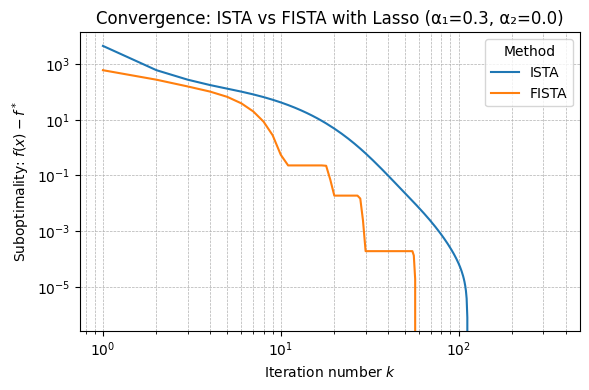

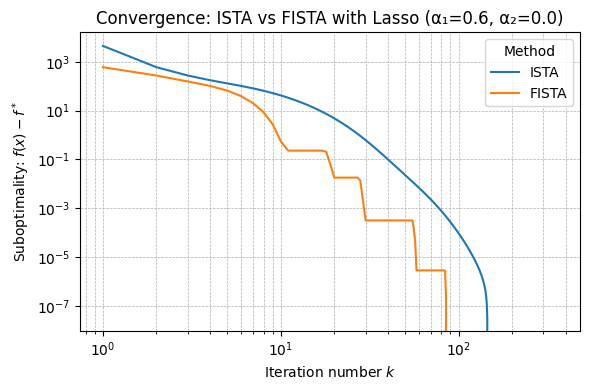

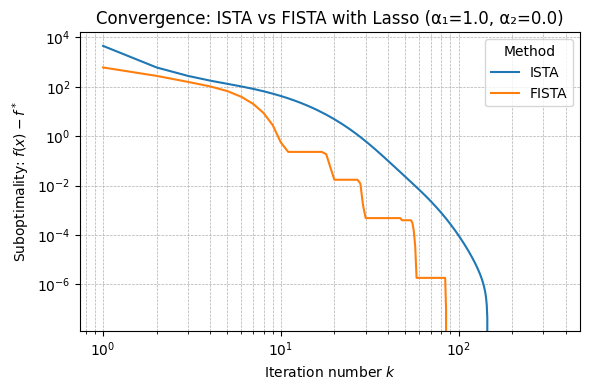

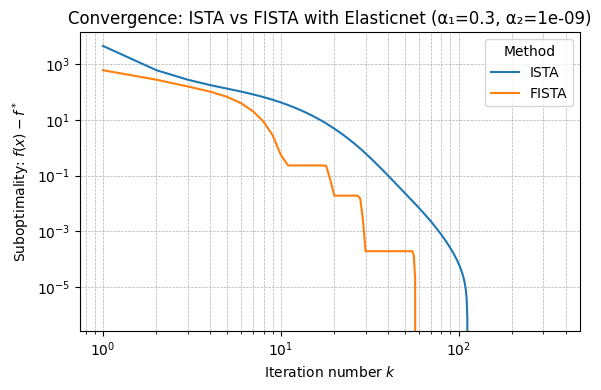

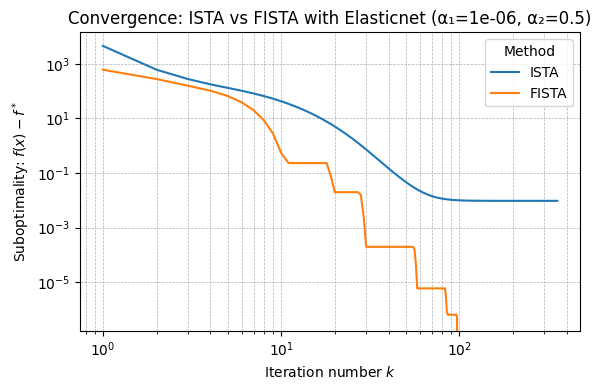

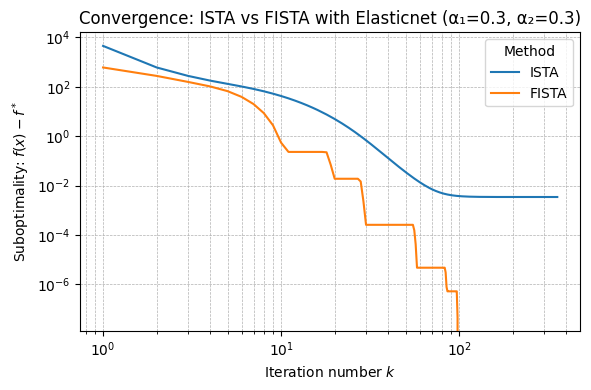

   method regularizer    alpha1        alpha2  iterations  runtime_s
0    ISTA       lasso  0.300000  0.000000e+00         359   0.004066
1   FISTA       lasso  0.300000  0.000000e+00          78   0.001827
2    ISTA       lasso  0.600000  0.000000e+00         359   0.003931
3   FISTA       lasso  0.600000  0.000000e+00         120   0.003105
4    ISTA       lasso  1.000000  0.000000e+00         359   0.004295
5   FISTA       lasso  1.000000  0.000000e+00         120   0.003019
6    ISTA  elasticnet  0.300000  1.000000e-09         359   0.004654
7   FISTA  elasticnet  0.300000  1.000000e-09          78   0.001820
8    ISTA  elasticnet  0.000001  5.000000e-01         354   0.004535
9   FISTA  elasticnet  0.000001  5.000000e-01          99   0.002772
10   ISTA  elasticnet  0.300000  3.000000e-01         356   0.004472
11  FISTA  elasticnet  0.300000  3.000000e-01          99   0.002466


In [89]:
records = []
n, m = A.shape[1], A.shape[0]

for reg in basic_regs:
    name, a1, a2 = reg['name'], reg['alpha1'], reg['alpha2']

    # 1) define g, grad_g, prox_h and compute L
    if name == 'lasso':
        def g(x):
            r = A @ x - b
            return 0.5 * r.dot(r)


        def grad_g(x):
            return A.T @ (A @ x - b)


        prox_h = lambda v, t: prox_l1(v, t * a1)
        L0 = estimate_lipschitz(A)
        L = L0

    elif name == 'elasticnet':
        def g(x):
            r = A @ x - b
            return 0.5 * r.dot(r) + a2 * x.dot(x)


        def grad_g(x):
            return A.T @ (A @ x - b) + 2 * a2 * x


        prox_h = lambda v, t: prox_elastic_net(v, t, a1, a2)
        L0 = estimate_lipschitz(A)
        L = L0 + 2 * a2

    else:
        continue

    # 2) run ISTA with history
    x0 = np.zeros(n)
    t_start = time.perf_counter()
    x_i, hist_i = ista(
        x0, g, grad_g, prox_h, L,
        backtracking=False,
        t_init=None,
        max_iter=500,
        tol=TOL,
        return_history=True
    )
    t_ista = time.perf_counter() - t_start

    # defensive check
    if hist_i is None or 'x' not in hist_i:
        raise RuntimeError(f"ISTA did not return history for regularizer='{name}'")

    # 3) build objective history for ISTA
    obj_i = [
        compute_objective(xk, A, b, name, a1, a2)
        for xk in hist_i['x']
    ]

    # 4) run FISTA with history
    t_start = time.perf_counter()
    x_f, hist_f = fista(
        A, b, name, a1, a2,
        max_iter=500,
        tol=TOL,
        return_history=True
    )
    t_fista = time.perf_counter() - t_start

    if hist_f is None or 'obj' not in hist_f:
        raise RuntimeError(f"FISTA did not return objective history for regularizer='{name}'")

    obj_f = hist_f['obj']

    # 5) plot convergence
    f_star = obj_f[-1]
    ks_i = np.arange(1, len(obj_i) + 1)
    ks_f = np.arange(1, len(obj_f) + 1)

    plt.figure(figsize=(6, 4))
    plt.loglog(ks_i, np.minimum.accumulate(np.array(obj_i) - f_star), '-', label='ISTA')
    plt.loglog(ks_f, np.minimum.accumulate(np.array(obj_f) - f_star), '-', label='FISTA')
    plt.title(f"Convergence: ISTA vs FISTA with {name.title()} (α₁={a1}, α₂={a2})")
    plt.xlabel('Iteration number $k$')
    plt.ylabel('Suboptimality: $f(x) - f^*$')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

    # 6) record summary
    records += [
        {'method': 'ISTA', 'regularizer': name, 'alpha1': a1, 'alpha2': a2,
         'iterations': len(obj_i), 'runtime_s': t_ista},
        {'method': 'FISTA', 'regularizer': name, 'alpha1': a1, 'alpha2': a2,
         'iterations': len(obj_f), 'runtime_s': t_fista}
    ]

df_basic = pd.DataFrame(records)
print(df_basic)


Ridge Regression via L-BFGS

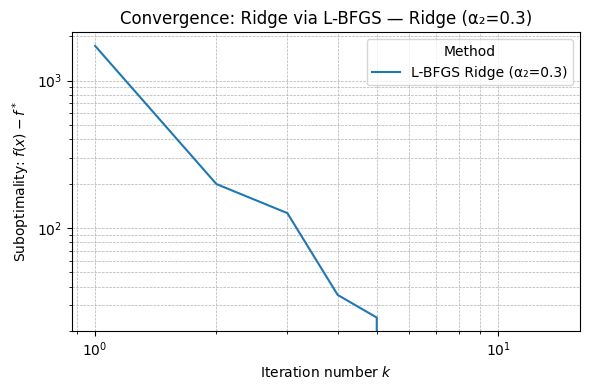

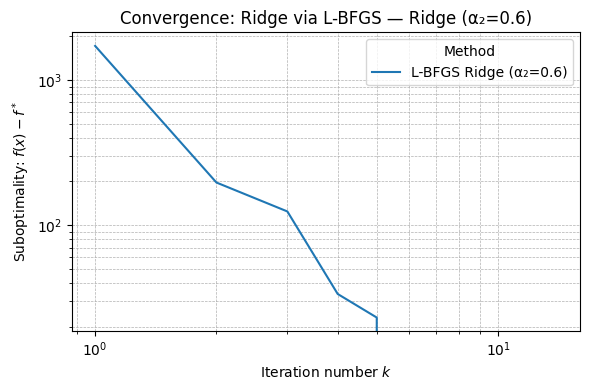

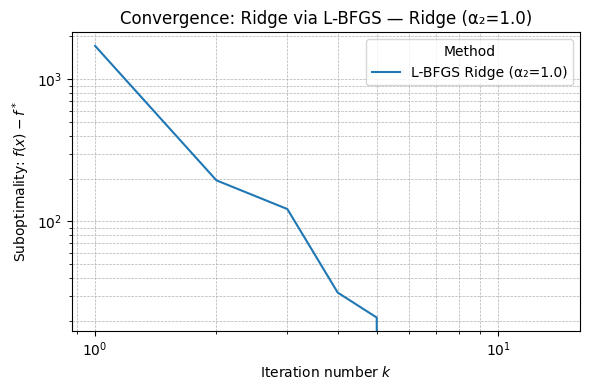

   method     regularizer  alpha1  alpha2  iterations  runtime_s
0  L-BFGS  Ridge (α₂=0.3)     0.0     0.3          14   0.001819
1  L-BFGS  Ridge (α₂=0.6)     0.0     0.6          14   0.001123
2  L-BFGS  Ridge (α₂=1.0)     0.0     1.0          14   0.000919


In [90]:
# ── Block 2: Ridge & “≈ Ridge” via L-BFGS ────────────────────────────────
eps = 1e-8
ridge_records = []

for reg in basic_regs:
    name, a1, a2 = reg['name'], reg['alpha1'], reg['alpha2']
    # select true Ridge or Elastic-Net ≃ Ridge
    is_ridge_case = (name == 'ridge') or (name == 'elasticnet' and a1 < eps)
    if not is_ridge_case:
        continue

    # choose plot label based on case
    if name == 'ridge':
        label = f"Ridge (α₂={a2})"
    else:
        label = f"Elastic Net ~ Ridge (α₁≈0, α₂={a2})"

    # configure L-BFGS for Ridge regression
    solver = LBFGSSolver(
        reg_type='ridge',
        alpha1=0.0,  # pure ℓ₂ in solver
        alpha2=a2,
        max_iter=500,
        tol=TOL
    )

    # run and time the solver
    t0 = time.perf_counter()
    solver.fit(A, b)
    runtime = time.perf_counter() - t0

    # plot convergence envelope with dynamic label
    ks = np.arange(1, len(solver.history_) + 1)
    plt.figure(figsize=(6, 4))
    plt.loglog(
        ks,
        np.minimum.accumulate(np.array(solver.history_) - solver.final_obj_),
        '-', label=f"L-BFGS {label}"
    )
    plt.title(f"Convergence: Ridge via L-BFGS — {label}")
    plt.xlabel('Iteration number $k$')
    plt.ylabel('Suboptimality: $f(x) - f^*$')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

    # record summary
    ridge_records.append({
        'method': 'L-BFGS',
        'regularizer': label,
        'alpha1': 0.0,
        'alpha2': a2,
        'iterations': len(solver.history_),
        'runtime_s': runtime
    })

# assemble into DataFrame
df_ridge = pd.DataFrame(ridge_records)
print(df_ridge)


FISTA vs FISTA-Delta Comparison

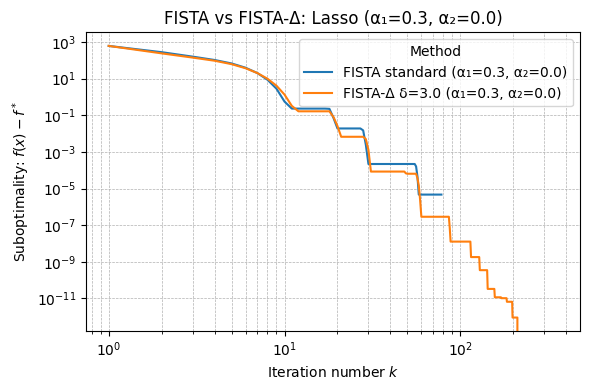

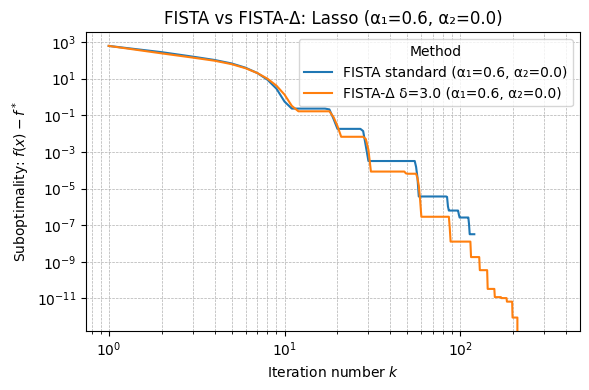

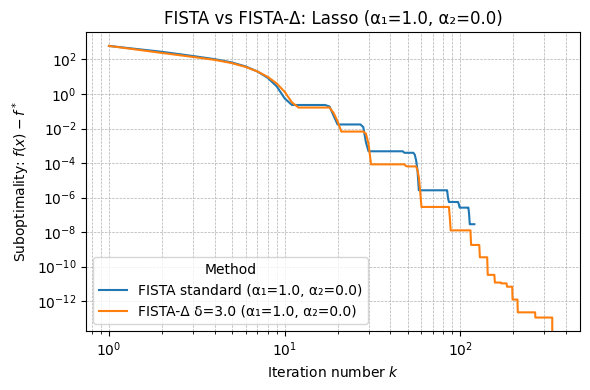

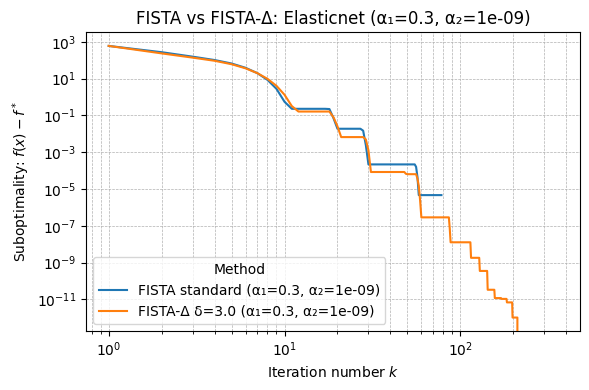

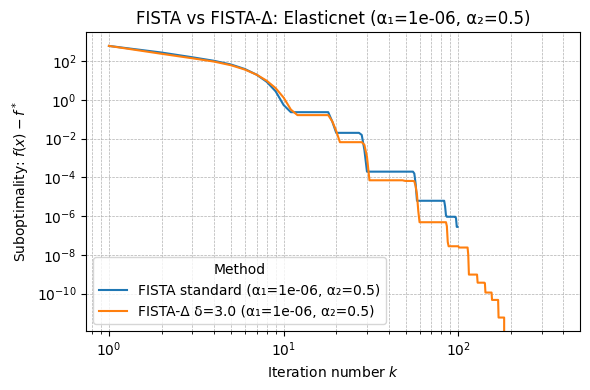

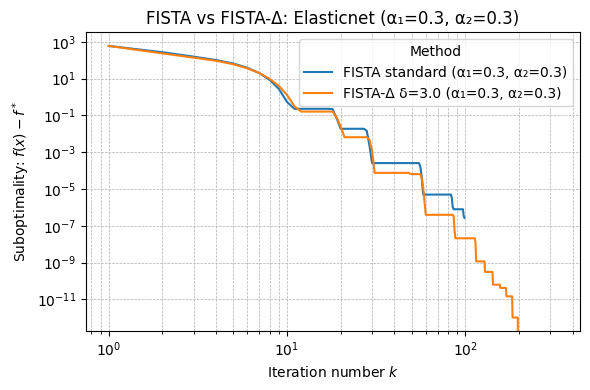

         method  delta regularizer    alpha1        alpha2  iterations  \
0         FISTA    NaN       lasso  0.300000  0.000000e+00          78   
1   FISTA-DELTA    3.0       lasso  0.300000  0.000000e+00         357   
2         FISTA    NaN       lasso  0.600000  0.000000e+00         120   
3   FISTA-DELTA    3.0       lasso  0.600000  0.000000e+00         357   
4         FISTA    NaN       lasso  1.000000  0.000000e+00         120   
5   FISTA-DELTA    3.0       lasso  1.000000  0.000000e+00         357   
6         FISTA    NaN  elasticnet  0.300000  1.000000e-09          78   
7   FISTA-DELTA    3.0  elasticnet  0.300000  1.000000e-09         357   
8         FISTA    NaN  elasticnet  0.000001  5.000000e-01          99   
9   FISTA-DELTA    3.0  elasticnet  0.000001  5.000000e-01         370   
10        FISTA    NaN  elasticnet  0.300000  3.000000e-01          99   
11  FISTA-DELTA    3.0  elasticnet  0.300000  3.000000e-01         329   

    runtime_s  
0    0.004887  
1    

In [91]:
# Compare standard FISTA (with history) and FISTA-Δ for Lasso&Elastic-Net
variants = []
delta = 3.0

for reg in basic_regs:
    name, a1, a2 = reg['name'], reg['alpha1'], reg['alpha2']
    # only Lasso/Elastic-Net with α₁>0
    if name not in ('lasso', 'elasticnet') or a1 <= 0.0:
        continue

    # 1) Standard FISTA with history
    t0 = time.perf_counter()
    x_std, hist_std = fista(
        A, b, name, a1, a2,
        max_iter=500,
        tol=TOL,
        return_history=True
    )
    t_std = time.perf_counter() - t0
    obj_std = hist_std['obj']

    # 2) FISTA-Δ (it already returns objs list)
    t0 = time.perf_counter()
    x_del, obj_del = fista_delta(
        A, b, name, a1, a2,
        delta=delta,
        max_iter=500,
        tol=TOL
    )
    t_del = time.perf_counter() - t0

    # 3) Plot suboptimality envelopes
    f_star = min(obj_std[-1], obj_del[-1])
    ks_std = np.arange(1, len(obj_std) + 1)
    ks_del = np.arange(1, len(obj_del) + 1)
    env_std = np.minimum.accumulate(np.array(obj_std) - f_star)
    env_del = np.minimum.accumulate(np.array(obj_del) - f_star)

    plt.figure(figsize=(6, 4))
    plt.loglog(ks_std, env_std, '-', label=f"FISTA standard (α₁={a1}, α₂={a2})")
    plt.loglog(ks_del, env_del, '-', label=f"FISTA-Δ δ={delta} (α₁={a1}, α₂={a2})")
    plt.title(f"FISTA vs FISTA-Δ: {name.title()} (α₁={a1}, α₂={a2})")
    plt.xlabel('Iteration number $k$')
    plt.ylabel('Suboptimality: $f(x) - f^*$')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

    # 4) Record summary
    variants += [
        {
            'method': 'FISTA', 'delta': None,
            'regularizer': name, 'alpha1': a1, 'alpha2': a2,
            'iterations': len(obj_std), 'runtime_s': t_std
        },
        {
            'method': 'FISTA-DELTA', 'delta': delta,
            'regularizer': name, 'alpha1': a1, 'alpha2': a2,
            'iterations': len(obj_del), 'runtime_s': t_del
        }
    ]

# 5) Aggregate into DataFrame
df_variants = pd.DataFrame(variants)
print(df_variants)
